In [1]:
%load_ext rich

import pathlib
import numpy as np
import pandas as pd

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_absolute_error as mae, make_scorer

import seaborn as sns
import matplotlib.pyplot as plt

from interpret.glassbox import ExplainableBoostingRegressor, APLRRegressor
from interpret import show

sns.set_context("notebook")
sns.set_palette("colorblind")

In [2]:
basedir = pathlib.Path.home() / "data" / "available_datasets"
df_stream = pd.read_csv(basedir / "stream_nitrogen" / "SINC_input_data_EDI.csv")

In [3]:
df_stream.head()

,Site,Datetime,Sample_Type,TP,TSP,SRP,TN,NO3,NH4,PP,...,EXO_fDOM_120h_lag,Press_kpa_120h_lag,SoilMoisture_120h_lag,EXO_SpCond_120delta,EXO_Temp_120delta,EXO_Turb_120delta,EXO_pH_120delta,EXO_fDOM_120delta,Press_kpa_120delta,SoilMoisture_120delta
0,TS_East,2018-01-22 16:35:00,Baseflow,5.6920,3.5179,2.7809,0.5512,0.552,0.0050,2.1741,...,NaN,NaN,0.1115,NaN,NaN,NaN,NaN,NaN,NaN,0.0125
1,TS_East,2018-02-28 15:10:00,Baseflow,7.0481,3.1527,1.9507,0.3439,0.362,0.0185,3.8954,...,4.988937,NaN,0.1350,24.75075,1.31850,-0.76750,0.01000,-0.233648,NaN,0.0080
2,TS_East,2018-03-20 14:10:00,Baseflow,12.4426,2.7000,0.5000,0.6172,0.587,0.0050,9.7426,...,3.308868,2.04100,0.1220,61.96175,-2.02375,-1.65325,0.02150,-0.647593,-0.2125,0.0045
3,TS_East,2018-04-04 14:00:00,Storm Event,10.8230,3.2835,1.4783,0.4033,0.248,0.0050,7.5395,...,11.785599,3.18525,0.1280,83.58150,0.60375,-8.77200,0.09775,-2.180811,-0.8195,-0.0200
4,TS_East,2018-04-04 18:00:00,Storm Event,30.3826,4.7192,2.0857,0.4653,0.195,0.0050,25.6634,...,11.587968,3.25025,0.1245,47.61350,0.35300,1.25850,0.02350,0.785274,-0.1790,-0.0025


In [4]:
df_stream["hour_of_day"] = df_stream["Datetime"].apply(lambda x: x.split(":")[0][-2:]).astype(float)
df_stream["month"] = df_stream["Datetime"].apply(lambda x: x.split("-")[1]).astype(float)
event = df_stream["Sample_Type"].values
for col in ["Site", "Datetime", "Sample_Type"]:
    df_stream.drop(col, axis=1, inplace=True)
target_cols = ["TP", "TSP", "SRP", "TN", "NO3", "NH4", "PP"]
targets = df_stream[target_cols].copy()
for col in target_cols:
    df_stream.drop(col, axis=1, inplace=True)
df_stream.shape

(680, 65)

In [5]:
targets.isna().sum()


TP     0
TSP    0
SRP    0
TN     0
NO3    0
NH4    0
PP     0
dtype: int64

In [6]:
df_stream.isna().sum().sort_values(ascending=False)


EXO_fDOM_120delta        275
EXO_Turb_120delta        274
SoilMoisture_120delta    273
EXO_pH_120delta          269
EXO_Temp_120delta        268
                        ... 
Press_kpa_5h_lag         169
Press_kpa_120h_lag       166
Press_kpa_24h_lag        162
hour_of_day                0
month                      0
Length: 65, dtype: int64

In [7]:
for col in df_stream.columns:
    df_stream[col] = df_stream[col].fillna(np.nanmedian(df_stream[col]))  # This probably should at least be different by event type

In [8]:
models = {}
scores = {}
for col in targets:
    print(f"***\nTarget: {col}")
    print(f"Quantiles:\n {targets[col].quantile([0, 0.05, 0.25, 0.5, 0.75, 0.95, 1])}\n")

    X = df_stream.copy()
    y = targets[col].copy()
    model = DecisionTreeRegressor(max_depth=11)
    score = cross_validate(model, X, y, cv=5, scoring=make_scorer(mae))
    scores[col] = score['test_score'].mean()
    print(f"MAE: {scores[col]:.3f} ± {score['test_score'].std():.3f}")
    if col != targets.columns[-1]:
        print("\n**\n\n")
    models[col] = model.fit(X, y)

***
Target: TP
Quantiles:
 0.00      1.652000
0.05      2.991450
0.25      5.502000
0.50      9.614900
0.75     19.244225
0.95    107.927160
1.00    488.942900
Name: TP, dtype: float64

MAE: 25.470 ± 6.480

**


***
Target: TSP
Quantiles:
 0.00      0.500000
0.05      1.837465
0.25      2.873625
0.50      4.088450
0.75      5.926050
0.95     10.125205
1.00    289.124400
Name: TSP, dtype: float64

MAE: 4.806 ± 3.200

**


***
Target: SRP
Quantiles:
 0.00      0.500000
0.05      0.500000
0.25      1.064700
0.50      1.879800
0.75      3.737325
0.95      9.384600
1.00    286.748900
Name: SRP, dtype: float64

MAE: 3.619 ± 1.901

**


***
Target: TN
Quantiles:
 0.00    0.025000
0.05    0.099700
0.25    0.197275
0.50    0.317100
0.75    0.626450
0.95    2.041660
1.00    2.788800
Name: TN, dtype: float64

MAE: 0.482 ± 0.288

**


***
Target: NO3
Quantiles:
 0.00    0.00500
0.05    0.00500
0.25    0.04575
0.50    0.10650
0.75    0.22800
0.95    1.60100
1.00    2.67000
Name: NO3, dtype: float64

In [9]:
# Explainable Model
expl_models = {}
expl_scores = {}
for col in targets:
    print(f"***\nTarget: {col}")
    print(f"Quantiles:\n {targets[col].quantile([0, 0.05, 0.25, 0.5, 0.75, 0.95, 1])}\n")

    X = df_stream.copy()
    y = targets[col].copy()
    model = ExplainableBoostingRegressor(interactions=10, reg_alpha=0.1, n_jobs=8, random_state=1331)
    score = cross_validate(model, X, y, cv=5, scoring=make_scorer(mae))
    expl_scores[col] = score['test_score'].mean()
    print(f"MAE: {expl_scores[col]:.3f} ± {score['test_score'].std():.3f}")
    if col != targets.columns[-1]:
        print("\n**\n\n")
    expl_models[col] = model.fit(X, y)

***
Target: TP
Quantiles:
 0.00      1.652000
0.05      2.991450
0.25      5.502000
0.50      9.614900
0.75     19.244225
0.95    107.927160
1.00    488.942900
Name: TP, dtype: float64

MAE: 22.323 ± 5.419

**


***
Target: TSP
Quantiles:
 0.00      0.500000
0.05      1.837465
0.25      2.873625
0.50      4.088450
0.75      5.926050
0.95     10.125205
1.00    289.124400
Name: TSP, dtype: float64

MAE: 2.919 ± 1.019

**


***
Target: SRP
Quantiles:
 0.00      0.500000
0.05      0.500000
0.25      1.064700
0.50      1.879800
0.75      3.737325
0.95      9.384600
1.00    286.748900
Name: SRP, dtype: float64

MAE: 2.723 ± 1.304

**


***
Target: TN
Quantiles:
 0.00    0.025000
0.05    0.099700
0.25    0.197275
0.50    0.317100
0.75    0.626450
0.95    2.041660
1.00    2.788800
Name: TN, dtype: float64

MAE: 0.425 ± 0.260

**


***
Target: NO3
Quantiles:
 0.00    0.00500
0.05    0.00500
0.25    0.04575
0.50    0.10650
0.75    0.22800
0.95    1.60100
1.00    2.67000
Name: NO3, dtype: float64

In [10]:
results = pd.DataFrame({
    "target": targets.columns,
    "decision_tree": [scores[c] for c in targets.columns],
    "explainable model": [expl_scores[c] for c in targets.columns]
})
results

,target,decision_tree,explainable model
0,TP,25.470226,22.322771
1,TSP,4.806209,2.919475
2,SRP,3.618573,2.722945
3,TN,0.482150,0.424576
4,NO3,0.354216,0.338682
5,NH4,0.013699,0.014894
6,PP,22.741639,21.138013


Let's look a little closer at the target distributions/predictions after taking log10

/tmp/ipykernel_1054055/2557533470.py:4: RuntimeWarning: invalid value encountered in log10
  sns.kdeplot(np.log10(expl_models[col].predict(X)), label="ET", linestyle=":")


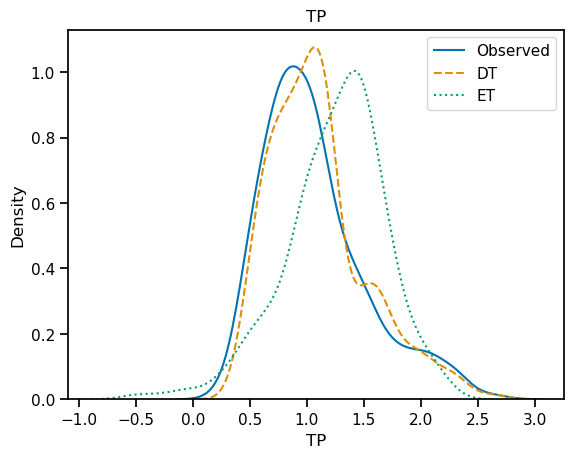

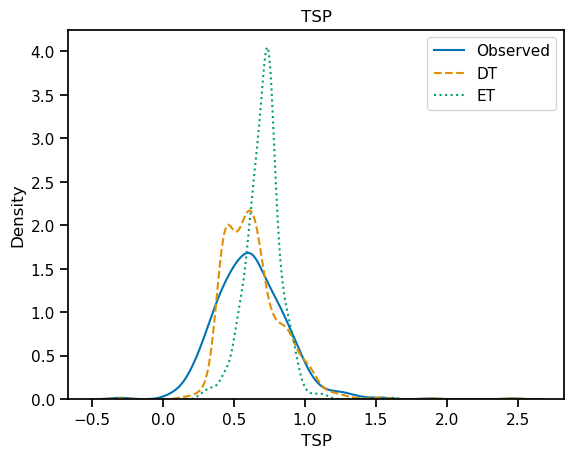

/tmp/ipykernel_1054055/2557533470.py:4: RuntimeWarning: invalid value encountered in log10
  sns.kdeplot(np.log10(expl_models[col].predict(X)), label="ET", linestyle=":")


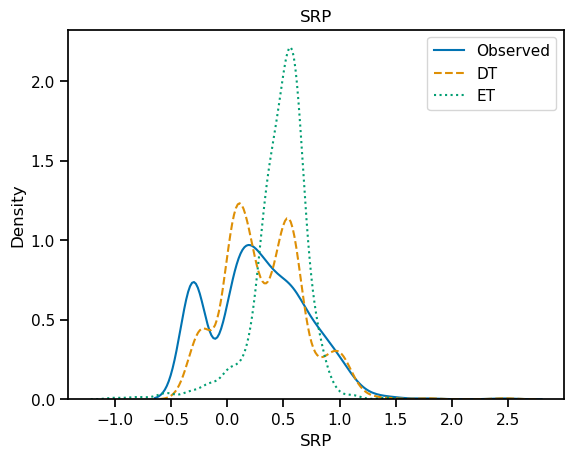

/tmp/ipykernel_1054055/2557533470.py:4: RuntimeWarning: invalid value encountered in log10
  sns.kdeplot(np.log10(expl_models[col].predict(X)), label="ET", linestyle=":")


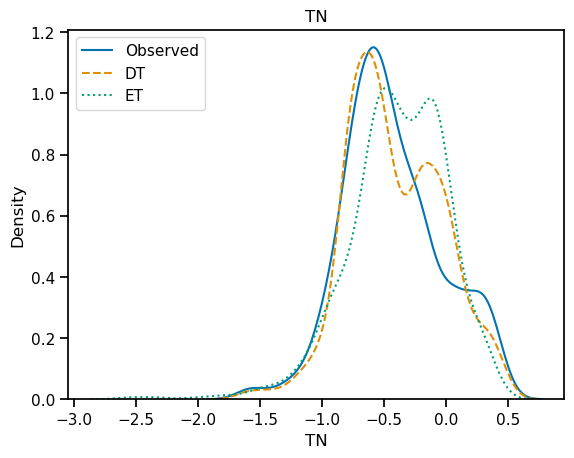

/tmp/ipykernel_1054055/2557533470.py:4: RuntimeWarning: invalid value encountered in log10
  sns.kdeplot(np.log10(expl_models[col].predict(X)), label="ET", linestyle=":")


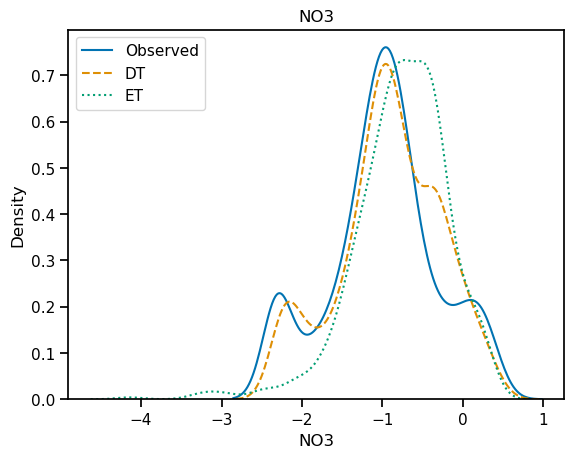

/tmp/ipykernel_1054055/2557533470.py:4: RuntimeWarning: invalid value encountered in log10
  sns.kdeplot(np.log10(expl_models[col].predict(X)), label="ET", linestyle=":")


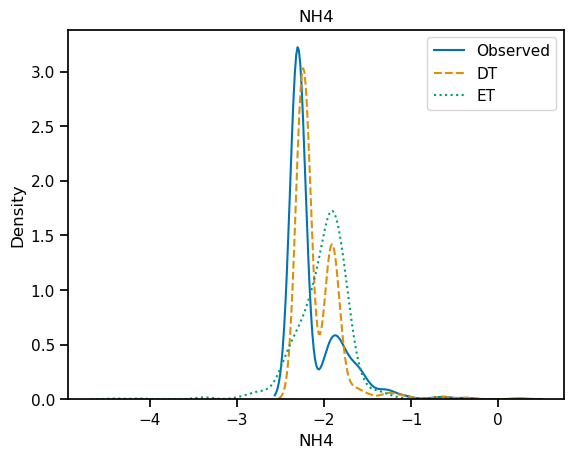

/home/jrings/mambaforge/envs/model_citizen/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jrings/mambaforge/envs/model_citizen/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_1054055/2557533470.py:4: RuntimeWarning: invalid value encountered in log10
  sns.kdeplot(np.log10(expl_models[col].predict(X)), label="ET", linestyle=":")


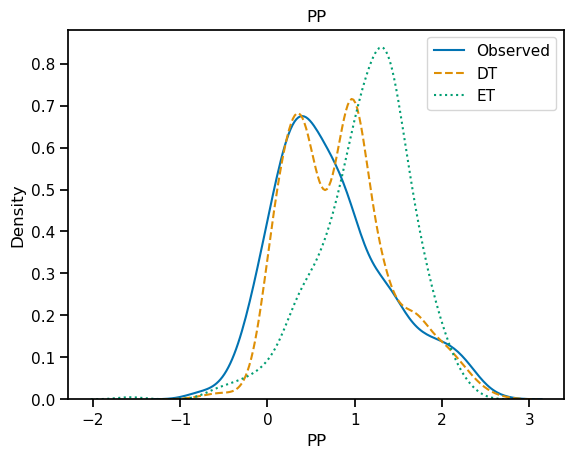

In [12]:
for col in targets:
    sns.kdeplot(np.log10(targets[col]), label="Observed")
    sns.kdeplot(np.log10(models[col].predict(X)), label="DT", linestyle='--')
    sns.kdeplot(np.log10(expl_models[col].predict(X)), label="ET", linestyle=":")
    plt.legend()
    plt.title(col)
    plt.show()
    plt.close()